<a href="https://www.kaggle.com/code/honganzhu/translator-of-traditional-chinese-poetry?scriptVersionId=200353373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Gemma - Translator of Traditional Chinese Poetry 



## Install dependencies

Install Keras and KerasNLP.

In [3]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

import os

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 256
lora_name = "translator"
lora_rank = 4
lr_value = 1e-4
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Load Dataset


In [4]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

from datasets import load_dataset

ds = load_dataset(
    "honganzhu/watermelody",
    split="train",
)
print(ds)
data = ds.with_format(
    "np", columns=["original", "translation"], output_all_columns=False
)
train = []

for x in data:
    item = f"<start_of_turn>user\n{x['original']}<end_of_turn>\n<start_of_turn>model\n{x['translation']}<end_of_turn>"
    length = len(tokenizer(item))
    # skip data if the token length is longer than our limit
    if length < token_limit:
        train.append(item)

print(len(train))
print(train[0])
print(train[1])
print(train[2])


Dataset({
    features: ['original', 'translation'],
    num_rows: 44
})
44
<start_of_turn>user
明月几时有?<end_of_turn>
<start_of_turn>model
How long will the full moon appear<end_of_turn>
<start_of_turn>user
把酒问青天<end_of_turn>
<start_of_turn>model
Wine cup in hand, I ask the sky<end_of_turn>
<start_of_turn>user
不知天上宫阙，今夕是何年<end_of_turn>
<start_of_turn>model
I do not know what time of the year, ’Twould be tonight in the palace on high<end_of_turn>


## Load Model

In [5]:
import keras
import keras_nlp

import time

gemma = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma.summary()

tick_start = 0


def tick():
    global tick_start
    tick_start = time.time()


def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()


text_gen("城阙辅三秦，风烟望五津")
text_gen("与君离别意，同是宦游人")
text_gen("海内存知己，天涯若比邻")
text_gen("无为在歧路，儿女共沾巾")

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
城阙辅三秦，风烟望五津<end_of_turn>
<start_of_turn>model
This is a beautiful and evocative line from a poem! It's a classic example of Chinese poetry, known as **"The Ballad of the Three Qin"**. 

Here's a breakdown of the meaning and context:

**城阙辅三秦 (chéngquè fǔ sān qín)**

* **城阙:**  Refers to the city gates and towers, symbols of strength and defense.
* **辅:**  Means "to support" or "to assist."
* **三秦:** Refers to the three Qin states, a historical region in northern China.

**This line suggests that the city gates and towers are strong and capable of defending the three Qin states.**

**风烟望五津 (fēng yān wàng wǔ jìn)**

* **风烟:**  Means "wind and smoke," evoking a sense of movement and change.
* **望:**  Means "to look at" or "to gaze upon."
* **五津:** Refers to the five rivers that flow into the Yellow River, a major river in China.

**This line suggests that
TOTAL TIME ELAPSED: 22.16s

Gemma output:
<start_of_turn>user
与君离别意，同是宦游人<end_of_turn>
<start_of_tur

## LoRA Fine-tuning

In [6]:
# Enable LoRA for the model and set the LoRA rank (4, 8 or 16).
gemma.backbone.enable_lora(rank=lora_rank)
gemma.summary()

# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

## Save LoRA for each epoch

Epoch 1/5
41/44 ━━━━━━━━━━━━━━━━━━━━ 2s 906ms/step - loss: 0.9933 - sparse_categorical_accuracy: 0.1733
Gemma output:
<start_of_turn>user
城阙辅三秦，风烟望五津<end_of_turn>
<start_of_turn>model
This is a beautiful and evocative line from the Chinese poem "The Ballad of the Three Qin" (三秦歌). 

**Translation:**

* **城阙辅三秦:**  "The city gates and walls support the three Qin."
* **风烟望五津:** "The wind and smoke look at the five rivers."

**Explanation:**

* **城阙辅三秦:** This line describes the grandeur and strength of the Qin dynasty, symbolized by the city gates and walls. 
* **风烟望五津:** This line evokes a sense of vastness and beauty, looking out over the five rivers.

**Context:**

This poem is a lament for the Qin dynasty, which was a powerful and influential empire in ancient China. The poet is reflecting on the legacy of the Qin dynasty and its impact on the land.


Let me know if you'd like to know more about the poem or the Qin dynasty! 
<end_of_turn>
TOTAL TIME ELAPSED: 22.48s

Gemma output:
<st

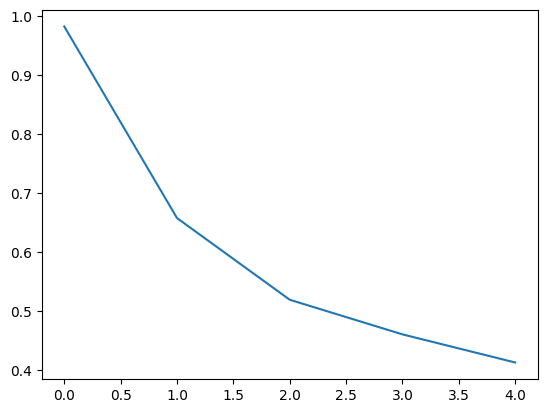

In [7]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/kaggle/working/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("城阙辅三秦，风烟望五津")
    text_gen("与君离别意，同是宦游人")
    text_gen("海内存知己，天涯若比邻")
    text_gen("无为在歧路，儿女共沾巾")

history = gemma.fit(train, epochs=train_epoch, batch_size=1, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()


# Final Comparison

**Original Poetry:**

城阙辅三秦，风烟望五津

与君离别意，同是宦游人

海内存知己，天涯若比邻

无为在歧路，儿女共沾巾


1. Translation by the same person in the training set:


“You leave the town walled far and wide
For mist-veiled land by riverside.”

***“I feel on parting sad and drear,
For both of us are strangers here.”***

***“If you have friends who know your heart,
Distance cannot keep you apart.”***

“At crossroads where we bid adieu,
Do not shed tears as others do!”

2. Translation by Gemma:

The city gate is guarded by three Qin states;
The wind and smoke drift to the five rivers’

***“I’ll part with you, my love, and be a wanderer, too.”***

***“Though the sea be wide, I know a friend;
Though the world be far, as near as heaven's bend.”***

“I do not make a move, yet I walk the path of the unknown;
My children, they share the wine.”